<div style="font-weight:bold;font-size:30px;margin-bottom:-5px">Labs Submission 1: Regularization</div>

*submitted by: Lixiao Hu, Moritz Raykowski and Robin Reiners*

---

<p style="font-weight: bold">Table of Content:</p>

* [Problem Definition](#problem-definition)
* [1. Question](#1)
* [2. Question](#2)
* [3. Question](#3)
* [4. Question](#4)
* [5. Question](#5)
* [6. Question](#6)

<a id='problem-definition'></a> <p style="text-decoration: underline; font-style: italic">Problem Definition:</p>
 
In this lab, we investigate the effect of regularization on prediction. Our setting is very simple and in line with the linear model in the 
lecture notes. In particular, we estimate the model
$$
y_i=\beta_1 x_{1 i}+\beta_2 x_{2 i}+\ldots \beta_p x_{p i}+\epsilon_i
$$
and we set
$$
\beta_1=2, \beta_2=3, \beta_j=0 \text { for } j>2
$$

We will work on a simulation exercise, i.e. we

* simulate data according to the model above many times
* estimate the model parameters using standard OLS, LASSO or Ridge
* compare bias and variance for an out-of-sample prediction at some point $x_0$.

_Here is some code for the simulation to get you started._

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

n_simulations = 100
n_observations = 100
n_regressors = 10
beta = np.concatenate(([2, 3], np.zeros(n_regressors-2)))

# out-of-sample observation of the features
x_0 = np.repeat(2, n_regressors)

# initialize vectors so that we can store results 
f0_ols = np.empty(n_simulations)
f0_lasso = np.empty(n_simulations)
f0_ridge = np.empty(n_simulations)

for s in range(n_simulations):
    # randomly drawn x variables
    matrix_X = np.random.multivariate_normal(
        mean=np.zeros(n_regressors), 
        cov=np.identity(n_regressors), # i.e. iid
        size=n_observations
    )
    # simulate y with true beta variables and normal noise
    vector_y = matrix_X @ beta + np.random.normal(size=chache_observations)

    # fit ols model and predict for out-of-sample feature set
    ols_model = linear_model.LinearRegression(fit_intercept=False)
    ols_model.fit(matrix_X, vector_y)
    f0_ols[s] = ols_model.predict([x_0])

    # fit lasso model and predict for out-of-sample feature set
    lasso_model = linear_model.LassoCV(cv=10, fit_intercept=False)
    lasso_model.fit(matrix_X, vector_y)
    f0_lasso[s] = lasso_model.predict([x_0])
    
    # fit ridge model and predict for out-of-sample feature set
    ridge_model = linear_model.RidgeCV(cv=10, fit_intercept=False)
    ridge_model.fit(matrix_X, vector_y)
    f0_ridge[s] = ridge_model.predict([x_0])

df = pd.DataFrame({
    'OLS': f0_ols,
    'Lasso': f0_lasso,
    'Ridge': f0_ridge
})

df

,OLS,Lasso,Ridge
0,9.379253,9.346377,9.261479
1,9.350137,9.253320,9.181326
2,10.439340,10.135111,10.322736
3,9.829023,9.715612,9.744516
4,9.373498,9.533077,9.249803
...,...,...,...
95,10.166495,10.032583,10.071628
96,10.057271,9.447386,9.905499
97,10.058878,9.431880,9.916343
98,10.028465,9.935724,9.904172


We implement a ModelPredictionSimulation class to create simulation objects (mps). This way we can parallelize the simulation_runs of generating random X variabels and fit them to the regression models, yielding significant reduction in computation time  

In [146]:
import numpy as np
import pandas as pd
from pathos.multiprocessing import ProcessingPool
import os

class ModelPredictionSimulation:
    def __init__(self, n_simulations, n_observations, n_regressors, rho):
        self.n_simulations = n_simulations
        self.n_observations = n_observations
        self.n_regressors = n_regressors
        self.rho = rho
        
        self.store_initial_params()
        self.update_x0_and_beta()
        
        self.results = pd.DataFrame(
            columns=['Run', 'OLS', 'Lasso', 'Ridge']
        ).set_index('Run')
        
    def store_initial_params(self):
        # initial params which are permanently stored
        self.initial_simulations = self.n_simulations
        self.initial_observations = self.n_observations
        self.initial_regressors = self.n_regressors
        self.initial_roh = self.rho
        
    def update_x0_and_beta(self):
        self.beta = np.concatenate(([2, 3], np.zeros(self.n_regressors-2)))
        self.x_0 = np.repeat(2, self.n_regressors)
        
    def reset_params(self):
        self.n_simulations = self.initial_simulations
        self.n_observations = self.initial_observations
        self.n_regressors = self.initial_regressors
        self.rho = self.initial_roh
        self.update_x0_and_beta()
        
    def simulate_data_batch(self, batch):
        results = []
        for s in batch:
            import numpy as np 
            from sklearn import linear_model
            # identitiy matrix
            sigma = np.full((self.n_regressors, self.n_regressors), self.rho)
            np.fill_diagonal(sigma, 1)
            # randomly drawn x variables
            matrix_X = np.random.multivariate_normal(
                mean=np.zeros(self.n_regressors),
                cov=sigma,
                size=self.n_observations
            )
            # simulate y with true beta variables and normal noise
            vector_y = matrix_X @ self.beta + np.random.normal(size=self.n_observations)

            # fit ols model and predict for out-of-sample feature set
            ols_model = linear_model.LinearRegression(fit_intercept=False, n_jobs=1)
            ols_model.fit(matrix_X, vector_y)
            ols_pred = ols_model.predict([self.x_0])[0]

            # fit lasso model and predict for out-of-sample feature set
            lasso_model = linear_model.LassoCV(cv=10, fit_intercept=False, n_jobs=1)
            lasso_model.fit(matrix_X, vector_y)
            lasso_pred = lasso_model.predict([self.x_0])[0]

            # fit ridge model and predict for out-of-sample feature set
            ridge_model = linear_model.RidgeCV(alphas=np.arange(0.1,1.1,0.1),cv=10, fit_intercept=False)
            ridge_model.fit(matrix_X, vector_y)
            ridge_pred = ridge_model.predict([self.x_0])[0]

            results.append({
                'OLS': ols_pred,
                'Lasso': lasso_pred,
                'Ridge': ridge_pred
            })
        return results
    
    def simulate_data(self):
        n_batches = os.cpu_count()
        batch_size = self.n_simulations // n_batches
        batches = [range(i*batch_size, (i+1)*batch_size) for i in range(n_batches)]
        if self.n_simulations % n_batches != 0:
            batches.append(range(n_batches*batch_size, self.n_simulations))

        pool = ProcessingPool()
        results = []
        for batch_results in pool.map(lambda batch: self.simulate_data_batch(batch), batches):
            results.extend(batch_results)
            batch_results_df = pd.DataFrame(batch_results)
            batch_results_df.index.name = "Run"
            self.results = pd.concat([self.results, batch_results_df], ignore_index=True)
            
        return results
    
    def get_results(self):
        if self.results.empty:
            self.simulate_data()
        return self.results
    
    def get_statistics(self):
        if self.results.empty:
            self.simulate_data()
        
        bias = self.results.mean() - (self.x_0 @ self.beta)
        variance = self.results.var()
        sqrd_error = (self.results - (self.x_0 @ self.beta))**2
        mse = sqrd_error.mean()
        
        return pd.concat([bias, variance, mse], axis=1, keys=['Bias', 'Variance', 'MSE'])
    
    def vary_parameter(self, parameter, values):
        results_list = []
        for i, value in enumerate(values):
            i+=1
            print(f'Iterating over {parameter}: {i} / {len(values)}', end='\r')
            
            if parameter == 'n_regressors':
                self.n_regressors = value
                self.update_x0_and_beta()
            elif parameter == 'n_simulations':
                self.n_simulations = value
            elif parameter == 'n_observations':
                self.n_observations = value
            elif parameter == 'rho':
                self.rho = value
                
            self.simulate_data()
            df = self.get_statistics()
            idx = pd.MultiIndex.from_tuples([(value, i) for i in df.index], names=[f'{parameter}', 'Model'])
            df.index = idx
            results_list.append(df)

        self.reset_params()
        results = pd.concat(results_list)
        return results

<p style="text-decoration: underline" id='1'>Lab-Question 1:</p>

*We will consider out-of-sample predictions at $x_0 = (2, 2, . . . , 2)$. What value of $f(x_0)$ do you expect?*

---

Concidering that the true betas are $\beta_1=2, \beta_2=3, \beta_j=0 \text { for } j>2$ we take the dot product of the beta vector and our feature vector $x_0$

In [144]:
beta @ x_0

10.0

<p style="text-decoration: underline" id='2'>Lab-Question 2:</p>

*Run the code as is. Plot the distribution of predictions $\hat{f}\left(x_0\right)$ for the different models. What do you observe?*

---


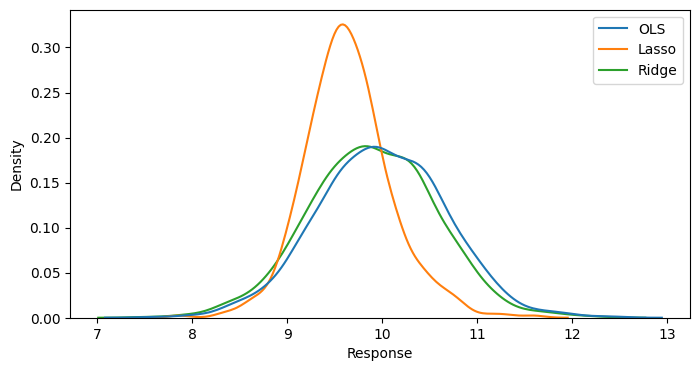

In [147]:
from IPython.display import display, HTML

# Create the plot
fig, axs = plt.subplots(ncols=1, figsize=(8, 4))

mps = ModelPredictionSimulation(
    n_simulations=1000,n_observations=100,n_regressors=10, rho=0
)

sns.kdeplot(mps.get_results())
plt.xlabel('Response')

# Display the plot centered within the cell
display(HTML("<style>.output { display: flex; justify-content: center; }</style>"))

**OLS** has the highest variance, which means that it is the most sensitive to changes in the data. This is not surprising, as OLS does not incorporate any regularization, so it can easily overfit to the data. Therefore OLS has the lowest bias as it can freely fit the noise in the data.

**Lasso** has the lowest variance, which means that it is the least sensitive to changes in the data. This can be explained by the fact that Lasso imposes a penalty on the sum of the absolute values of the coefficients, which encourages sparsity in the model. By forcing some coefficients to be exactly zero, Lasso can effectively reduce the dimensionality of the problem, leading to a more stable model. This comes at the cost of introducing the highest bias.

**Ridge** seems to be inbetween OLS and Lasso. Ridge, which tends to spread the weights of the features more evenly does not give zero weight to $\beta_1$ and $\beta_2$ and therefore is not as biased as Lasso.

Overall, these observations illustrate the trade-offs between bias and variance in regularized regression. By adding a penalty term to the loss function, we can control the complexity of the model and prevent overfitting, but we also introduce a bias that may make it harder to capture the true relationships in the data.

<p style="text-decoration: underline" id='3'>Lab-Question 3:</p>

Compute bias, variance and mean squared error for the three different models at $x_0$, our out-of-sample observation.

___


In [148]:
mps.get_statistics().round(4)

,Bias,Variance,MSE
OLS,-0.0051,0.4527,0.4522
Lasso,-0.3606,0.2115,0.3413
Ridge,-0.1025,0.4456,0.4557


<p style="text-decoration: underline" id='4'>Lab-Question 4:</p>

How do bias and variance depend on the number of irrelevant regressors?

---

When comparing OLS, Lasso, and Ridge with a varying number of irrelevant regressors, the bias and variance of the models will be affected differently.

For OLS, as the number of irrelevant regressors increases, the bias remains relatively constant at zero als OLS is a true estimator. The variance on the otherhand increases. This is because OLS is not able to effectively eliminate the impact of irrelevant features, leading to overfitting and increased variance. As a result, the model becomes more sensitive to changes in the data and the predictions become less stable (i.e. increasing MSE).

For Lasso, as the number of irrelevant regressors increases, the bias increases. This is because Lasso uses L1 regularization, which encourages sparsity in the model by setting some of the coefficients to zero. As a result, features will be effectively eliminated from the model, thus lasso is not very sensetive in terms of variance and MSE.

For Ridge, as the number of irrelevant regressors increases, the bias only slightly increases. This is because Ridge uses L2 regularization, which spreads the weights of the features more evenly. Thus introducing less bias as Lasso, but leading to a less stable model. As a result, the model becomes more likely to underfit the data and the predictions become less accurate.

In [75]:
sensitivity_analysis_regressors = mps.vary_parameter(
    parameter='n_regressors', values=np.arange(3,21)
)

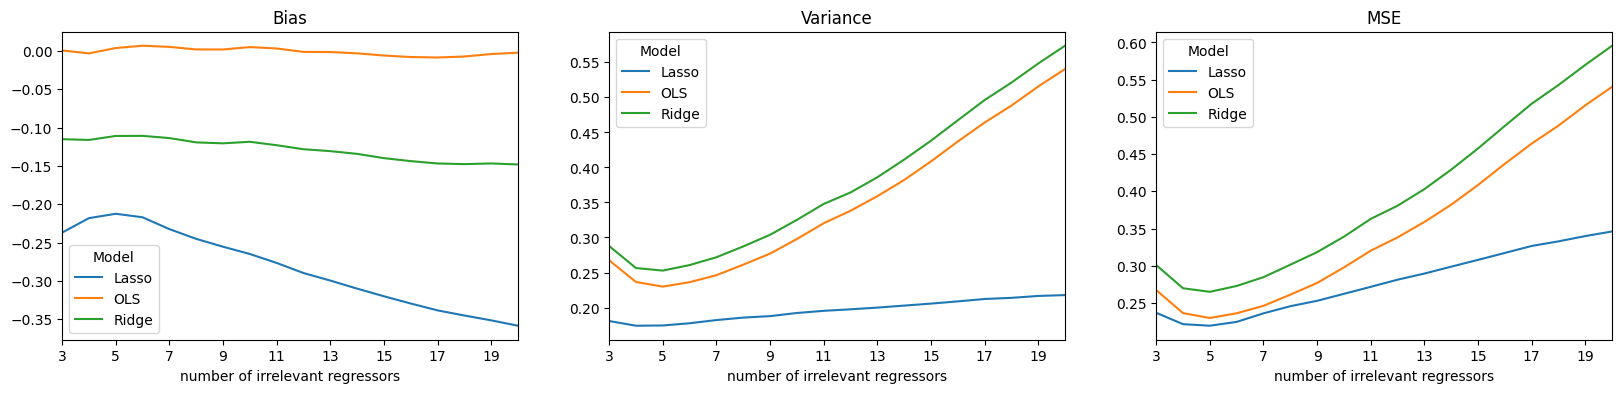

In [99]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
# Move the multi-index to columns
for i, col in enumerate(sensitivity_analysis_regressors.columns):
    (sensitivity_analysis_regressors
        .reset_index()
        .pivot(index='n_regressors', columns='Model', values=col)
        .plot(ax=axs[i])
    )
    axs[i].set_xlim(3,20)
    axs[i].set_xticks(np.arange(3,21,2))
    axs[i].set_xlabel('number of irrelevant regressors')
    axs[i].set_title(col)

<p style="text-decoration: underline" id='5'>Lab-Question 5:</p>

How do bias and variance depend on the number of observations?

---

**Bias**: As the number of observations increases, the bias of OLS remains constantly zero, as OLS is a true estimator and the bias of Lasso and Ridge decrease. This is because with more data, the model has more information to accurately estimate the true relationships between the predictors and the target variable. As Lasso forces some betas to exact zero, it has the highest bias (as discussed previously). 

**Variance**: As the number of observations increases, the variance of all models tend to decrease due to the Central Limit Theorem (CLT). The CLT states that the distribution of the sample mean approaches a normal distribution as the sample size increases, regardless of the shape of the original population distribution. In other words, as the number of observations increases, the distribution of the estimates becomes more tightly centered around the true value, and the variance of the estimates decreases.

In the case of linear regression, the variance of the prediction depends on the variance of the error term in the model. As the sample size increases, the variance of the error term tends to decrease because there are more observations to estimate the true relationship between the dependent and independent variables. Therefore, the variance of the prediction also tends to decrease as the number of observations increases.

In [76]:
sensitivity_analysis_observations = mps.vary_parameter(
    parameter='n_observations', values=np.arange(100,1000,100)
)

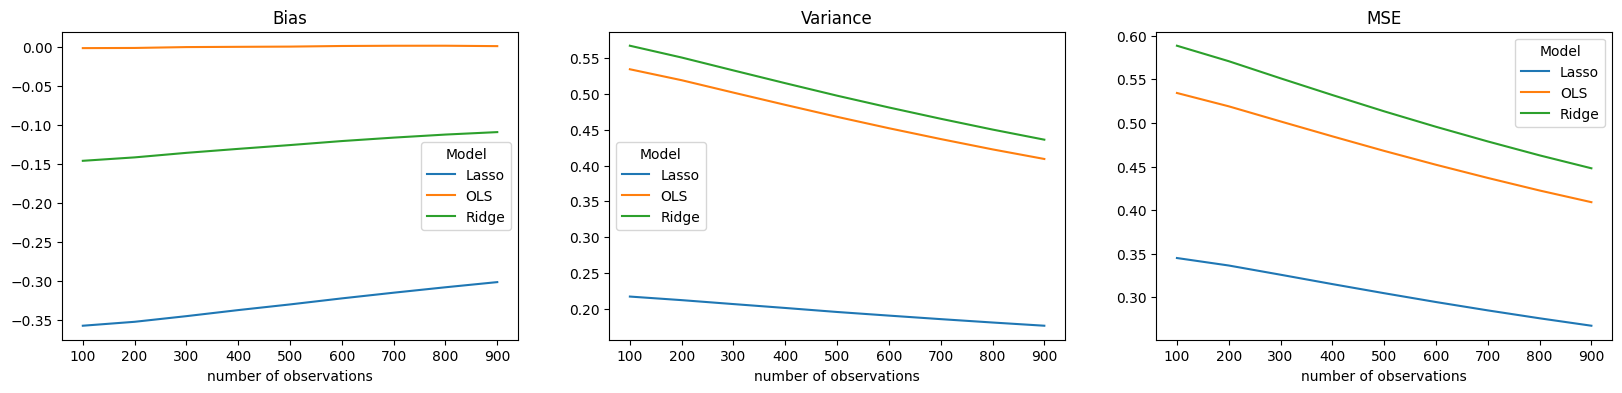

In [98]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
# Move the multi-index to columns
for i, col in enumerate(sensitivity_analysis_observations.columns):
    (sensitivity_analysis_observations
        .reset_index()
        .pivot(index='n_observations', columns='Model', values=col)
        .plot(ax=axs[i])
    )

    axs[i].set_xlabel('number of observations')
    axs[i].set_title(col)

<p style="text-decoration: underline" id='6'>Lab-Question 6:</p>

The simulation above assumes that regressors are uncorrelated. How do results change when correlation between regressors is instead given by $p > 0$?

---


In [126]:
sensitivity_analysis_rho = mps.vary_parameter(
    parameter='rho', values=np.arange(0,1.1,0.1)
)

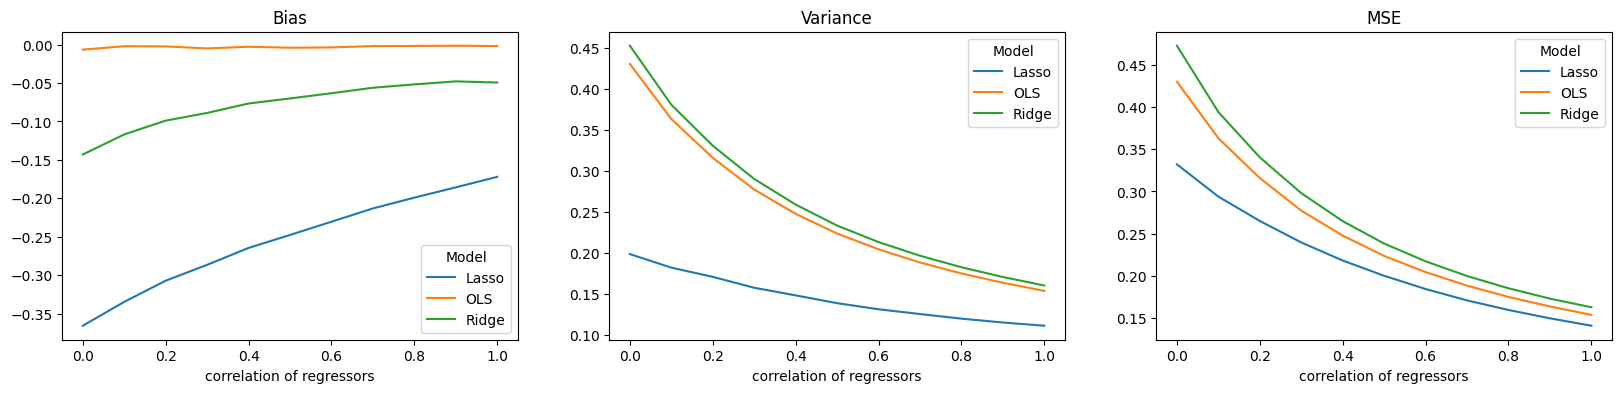

In [128]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
# Move the multi-index to columns
for i, col in enumerate(sensitivity_analysis_rho.columns):
    (sensitivity_analysis_rho
        .reset_index()
        .pivot(index='rho', columns='Model', values=col)
        .plot(ax=axs[i])
    )

    axs[i].set_xlabel('correlation of regressors')
    axs[i].set_title(col)

We observe, that the closer the correlation of the regressors tends to perfect correlation, bias, variance and MSE decrease for all Models. Thinking of the extrem case, if all regressors are perfectly correlated, it does not matter which one makes it into the model, as one holds perfect information about the other.